# 2025.1105

process LOD data

> The Length of Day (LOD) is a measure of the difference between the observed and nominal (86,400 s) duration of a day (Gross, 2015). LOD is variable over time, with variations ranging from subdaily to geological time scales. It has been shown that the secular trend on geological time scale is caused almost entirely by the opposing actions of lunar tidal friction and Glacial Isostatic Adjustment (GIA, Kiani Shahvandi, Adhikari, Dumberry, Mishra, & Soja, 2024). Atmosphere and, to a lesser degree oceans, are the main drivers of LOD variations up to interannual time scales (see Gross, 2015 and references therein for a review).  
> (Shahvandi+ 2024)

> LOD data were obtained from the Earth orientation center at <https://hpiers.obspm.fr/eop-pc/index.php>  
> (Rosat & Gillet, 2023).

Daily data is obtained from IERS C04 solution <https://hpiers.obspm.fr/eop-pc/index.php?index=C04>

In [1]:
import platform
import sys # python 3.9.16
import os

import numpy             as np # numpy 1.23.2
np.set_printoptions(precision=5, floatmode='fixed', suppress=True)

import pandas            as pd # pandas 2.0.3
from datetime import datetime, timedelta

import matplotlib        as mpl # matplotlib 3.7.1
import matplotlib.pyplot as plt

print(f"Python Platform: {platform.platform()}")
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f" Numpy {np.__version__}")
print(f"Matplotlib {mpl.__version__}")

Python Platform: macOS-15.5-arm64-arm-64bit
Python 3.9.22 | packaged by conda-forge | (main, Apr 14 2025, 23:36:04) 
[Clang 18.1.8 ]
Pandas 2.1.4
 Numpy 1.23.2
Matplotlib 3.7.1


## READ DATA

In [2]:
# 小数年（Fractional Year）を計算する関数を定義
def get_fractional_year(date):
    """
    datetimeオブジェクトから小数年を計算する。
    その日の正午を想定し、Year + (DayOfYear - 0.5) / DaysInYear を採用。
    """
    year = date.year
    day_of_year = date.timetuple().tm_yday
    
    # その年の総日数を計算 (うるう年を考慮)
    if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
        days_in_year = 366
    else:
        days_in_year = 365
    
    # 日付をその日の真ん中 (正午) に対応させる: (通算日 - 0.5)
    fractional_year = year + (day_of_year - 0.5) / days_in_year
    return fractional_year

In [3]:
def read_iers_data(file_path):
    # データの読み込み
    # ヘッダー行をスキップし、スペース区切りで読み込みます。
    df = pd.read_csv(
        file_path,
        sep='\s+',
        skiprows=2,
        header=None,
        names=['Year', 'Month', 'Day', 'lod', 'sigma'],
        engine='python' # '\s+'を使うため
    )

    # 日付オブジェクト (datetime) の作成
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    # 小数年の計算を適用
    df['Fractional_Year'] = df['Date'].apply(get_fractional_year)
    
    return df

In [5]:
read_src = "../data/raw/iers_C04_daily_raw_2000-2025.lod"
lod_raw_df = read_iers_data(read_src)
lod_raw_df.head()

,Year,Month,Day,lod,sigma,Date,Fractional_Year
0,2000,1,1,0.9394,0.0274,2000-01-01,2000.001366
1,2000,1,2,0.8034,0.0289,2000-01-02,2000.004098
2,2000,1,3,0.6680,0.0282,2000-01-03,2000.006831
3,2000,1,4,0.5441,0.0258,2000-01-04,2000.009563
4,2000,1,5,0.4369,0.0243,2000-01-05,2000.012295


In [6]:
read_src = "../data/raw/iers_C04_daily_rmTidal_2000-2025.lod"
lod_rmT_df = read_iers_data(read_src)
lod_rmT_df.head()

,Year,Month,Day,lod,sigma,Date,Fractional_Year
0,2000,1,1,0.9718,0.0274,2000-01-01,2000.001366
1,2000,1,2,0.9506,0.0289,2000-01-02,2000.004098
2,2000,1,3,0.9314,0.0282,2000-01-03,2000.006831
3,2000,1,4,0.9115,0.0258,2000-01-04,2000.009563
4,2000,1,5,0.8827,0.0243,2000-01-05,2000.012295


## process LOD data to 0.25 yr interval

1 yr MOVING-AVERAGE filtering to remove seasonal variation (AAM, OAM effects)

In [7]:
def get_moving_average(df_daily, target_times, value_col='lod', time_col='Fractional_Year'):
    """
    日次データ (Fractional Year) を特定の四半期時系列に平均化する。
    
    ターゲットとなる時間点 t を中心とする [t - 0.125, t + 0.125) の期間の
    元のデータの平均値と標準偏差を計算する。

    Args:
        df_daily (pd.DataFrame): 日次データフレーム。
        target_times (np.array): 平均化したい小数年時系列。
        value_col (str): 平均化する値の列名 ('lod'など)。
        time_col (str): 小数年が入っている列名 ('Fractional_Year')。

    Returns:
        pd.DataFrame: 四半期平均値と四半期時間のデータフレーム。
    """
    results = []
    
    # ターゲット時間点 t を中心とする平均化の半期間 (0.25年/2)
    #half_period = (1999.1251 - 1999.3753) / -2  # 約0.125年
    half_period = 0.5  # 1年周期をフィルタリング
    
    for t in target_times:
        # ターゲット時間点 t を中心とする 0.25 年の窓内のデータを選択
        window_start = t - half_period
        window_end = t + half_period
        
        # DataFrameのフィルタリング
        window_data = df_daily[
            (df_daily[time_col] >= window_start) & 
            (df_daily[time_col] < window_end)
        ]
        
        avg_lod = np.nan
        std_lod = np.nan
        
        if not window_data.empty:
            # 窓内にデータがある場合のみ平均値と標準偏差を計算
            avg_lod = window_data[value_col].mean()
            std_lod = window_data[value_col].std()
        
        results.append({
            'YEAR': t,
            f'avg_{value_col}': avg_lod,
            f'std_{value_col}': std_lod
        })
    
    df_quarterly = pd.DataFrame(results)
    df_quarterly.set_index('YEAR', inplace=True)
    return df_quarterly

In [8]:
def get_sampling(df_daily, target_times):
    """
    sampling daily data for the closest time to the target time.
    """
    
    print(df_daily.index.values)
    sampled_data = []
    for target_time in target_times:
        # Find the index of the closest time
        closest_time = np.abs(df_daily.index.values - target_time).argmin()
        
        if closest_time == 0 or np.abs(df_daily.index.values - target_time)[closest_time] > 0.25:
            closest_time = np.nan
            avg_sampled = np.nan
            std_sampled = np.nan
        else:
            avg_sampled = df_daily.iloc[closest_time]['avg_lod']
            std_sampled = df_daily.iloc[closest_time]['std_lod']
        
        print(target_time, closest_time)
        sampled_data.append({
            'YEAR': target_time,
            'avg_lod': avg_sampled,
            'std_lod': std_sampled
        })
    return pd.DataFrame(sampled_data).set_index('YEAR')

In [9]:
def get_derivative(df, dt=0.25, value_col='avg_lod', std_col='std_lod'):
    """
    Calculate the time derivative of the specified column in the DataFrame.
    
    Args:
        df (pd.DataFrame): Input DataFrame with a time index.
        dt (float): Time step for the derivative calculation.
        value_col (str): Column name for which to calculate the derivative.
        std_col (str): Column name for the standard deviation (D(std)/DT = sqrt(std(t)**2 + std(t-1)**2)/dt**2).
        
    Returns:
        pd.DataFrame: DataFrame containing the derivative values.
    """
    df_derivative = df.copy()
    df_derivative[value_col] = df_derivative[value_col].diff() / dt
    df_derivative[std_col] = np.sqrt(
        df_derivative[std_col]**2 + df_derivative[std_col].shift(1)**2
    ) / dt

    df_derivative.index += dt  # シフトによるインデックスのズレを補正
    
    return df_derivative

In [10]:
# --- データの前処理 (前回の結果を使用) ---
# df_daily (日次データフレーム) が前回の実行により準備されていると仮定

# ターゲット時間点
target_times = [1999.1251, 1999.3753, 1999.6254, 1999.8756, 
                2000.1254, 2000.3749, 2000.6244, 2000.8739, 
                2001.1237, 2001.3739, 2001.6241, 2001.8742, 
                2002.1244, 2002.3746, 2002.6247, 2002.8749, 
                2003.1251, 2003.3753, 2003.6254, 2003.8756, 
                2004.1254, 2004.3749, 2004.6244, 2004.8739, 
                2005.1237, 2005.3739, 2005.6241, 2005.8742, 
                2006.1244, 2006.3746, 2006.6247, 2006.8749, 
                2007.1251, 2007.3753, 2007.6254, 2007.8756, 
                2008.1254, 2008.3749, 2008.6244, 2008.8739, 
                2009.1237, 2009.3739, 2009.6241, 2009.8742, 
                2010.1244, 2010.3746, 2010.6247, 2010.8749, 
                2011.1251, 2011.3753, 2011.6254, 2011.8756, 
                2012.1254, 2012.3749, 2012.6244, 2012.8739, 
                2013.1237, 2013.3739, 2013.6241, 2013.8742, 
                2014.1244, 2014.3746, 2014.6247, 2014.8749, 
                2015.1251, 2015.3753, 2015.6254, 2015.8756, 
                2016.1254, 2016.3749, 2016.6244, 2016.8739, 
                2017.1237, 2017.3739, 2017.6241, 2017.8742, 
                2018.1244, 2018.3746, 2018.6247, 2018.8749, 
                2019.1251, 2019.3753, 2019.6254, 2019.8756, 
                2020.1254, 2020.3749, 2020.6244, 2020.8739, 
                2021.1237, 2021.3739, 2021.6241, 2021.8742, 
                2022.1244, 2022.3746, 2022.6247, 2022.8749, 
                2023.1251, 2023.3753, 2023.6254, 2023.8756, 
                2024.1254, 2024.3749, 2024.6244, 2024.8739, 
                2025.1237, 2025.3739, 2025.6241, 2025.8742, 
                2026.1244, 2026.3746, 2026.6247, 2026.8749, 
                2027.1251, 2027.3753, 2027.6254, 2027.8756, 
                2028.1254, 2028.3749, 2028.6244, 2028.8739, 
                2029.1237, 2029.3739, 2029.6241, 2029.8742, 
                2030.1244, 2030.3746, 2030.6247, 2030.8749]
target_times = np.array(target_times)

# 関数を実行
lod_raw_filtered = get_moving_average(lod_raw_df, lod_rmT_df['Fractional_Year'], value_col='lod')
lod_rmT_filtered = get_moving_average(lod_rmT_df, lod_rmT_df['Fractional_Year'], value_col='lod')
lod_rmT_qaverage = get_moving_average(lod_rmT_df, target_times, value_col='lod')
lod_raw_fquarter = get_sampling(lod_raw_filtered, target_times)
lod_rmT_fquarter = get_sampling(lod_rmT_filtered, target_times)

daily = lod_raw_df['Fractional_Year'].diff().mean() # 1 day in year
DlodDT_rmT_filtered = get_derivative(lod_rmT_filtered, dt=daily, value_col='avg_lod', std_col='std_lod')
DlodDT_rmT_fquarter = get_sampling(DlodDT_rmT_filtered, target_times) # std is too large due to small dt

DlodDT_rmT_qaverage = get_derivative(lod_rmT_qaverage, dt=0.25, value_col='avg_lod', std_col='std_lod')

display(lod_raw_fquarter)
display(lod_rmT_fquarter)
display(DlodDT_rmT_fquarter)

[2000.00137 2000.00410 2000.00683 ... 2025.75753 2025.76027 2025.76301]
1999.1251 nan
1999.3753 nan
1999.6254 nan
1999.8756 nan
2000.1254 45
2000.3749 137
2000.6244 228
2000.8739 319
2001.1237 411
2001.3739 502
2001.6241 593
2001.8742 685
2002.1244 776
2002.3746 867
2002.6247 959
2002.8749 1050
2003.1251 1141
2003.3753 1232
2003.6254 1324
2003.8756 1415
2004.1254 1506
2004.3749 1598
2004.6244 1689
2004.8739 1780
2005.1237 1872
2005.3739 1963
2005.6241 2054
2005.8742 2146
2006.1244 2237
2006.3746 2328
2006.6247 2420
2006.8749 2511
2007.1251 2602
2007.3753 2693
2007.6254 2785
2007.8756 2876
2008.1254 2967
2008.3749 3059
2008.6244 3150
2008.8739 3241
2009.1237 3333
2009.3739 3424
2009.6241 3515
2009.8742 3607
2010.1244 3698
2010.3746 3789
2010.6247 3881
2010.8749 3972
2011.1251 4063
2011.3753 4154
2011.6254 4246
2011.8756 4337
2012.1254 4428
2012.3749 4520
2012.6244 4611
2012.8739 4702
2013.1237 4794
2013.3739 4885
2013.6241 4976
2013.8742 5068
2014.1244 5159
2014.3746 5250
2014.6247 5342

,avg_lod,std_lod
YEAR,,
1999.1251,NaN,NaN
1999.3753,NaN,NaN
1999.6254,NaN,NaN
1999.8756,NaN,NaN
2000.1254,0.683869,0.453673
...,...,...
2029.8742,NaN,NaN
2030.1244,NaN,NaN
2030.3746,NaN,NaN


,avg_lod,std_lod
YEAR,,
1999.1251,NaN,NaN
1999.3753,NaN,NaN
1999.6254,NaN,NaN
1999.8756,NaN,NaN
2000.1254,0.64004,0.323966
...,...,...
2029.8742,NaN,NaN
2030.1244,NaN,NaN
2030.3746,NaN,NaN


,avg_lod,std_lod
YEAR,,
1999.1251,NaN,NaN
1999.3753,NaN,NaN
1999.6254,NaN,NaN
1999.8756,NaN,NaN
2000.1254,-0.715803,167.005562
...,...,...
2029.8742,NaN,NaN
2030.1244,NaN,NaN
2030.3746,NaN,NaN


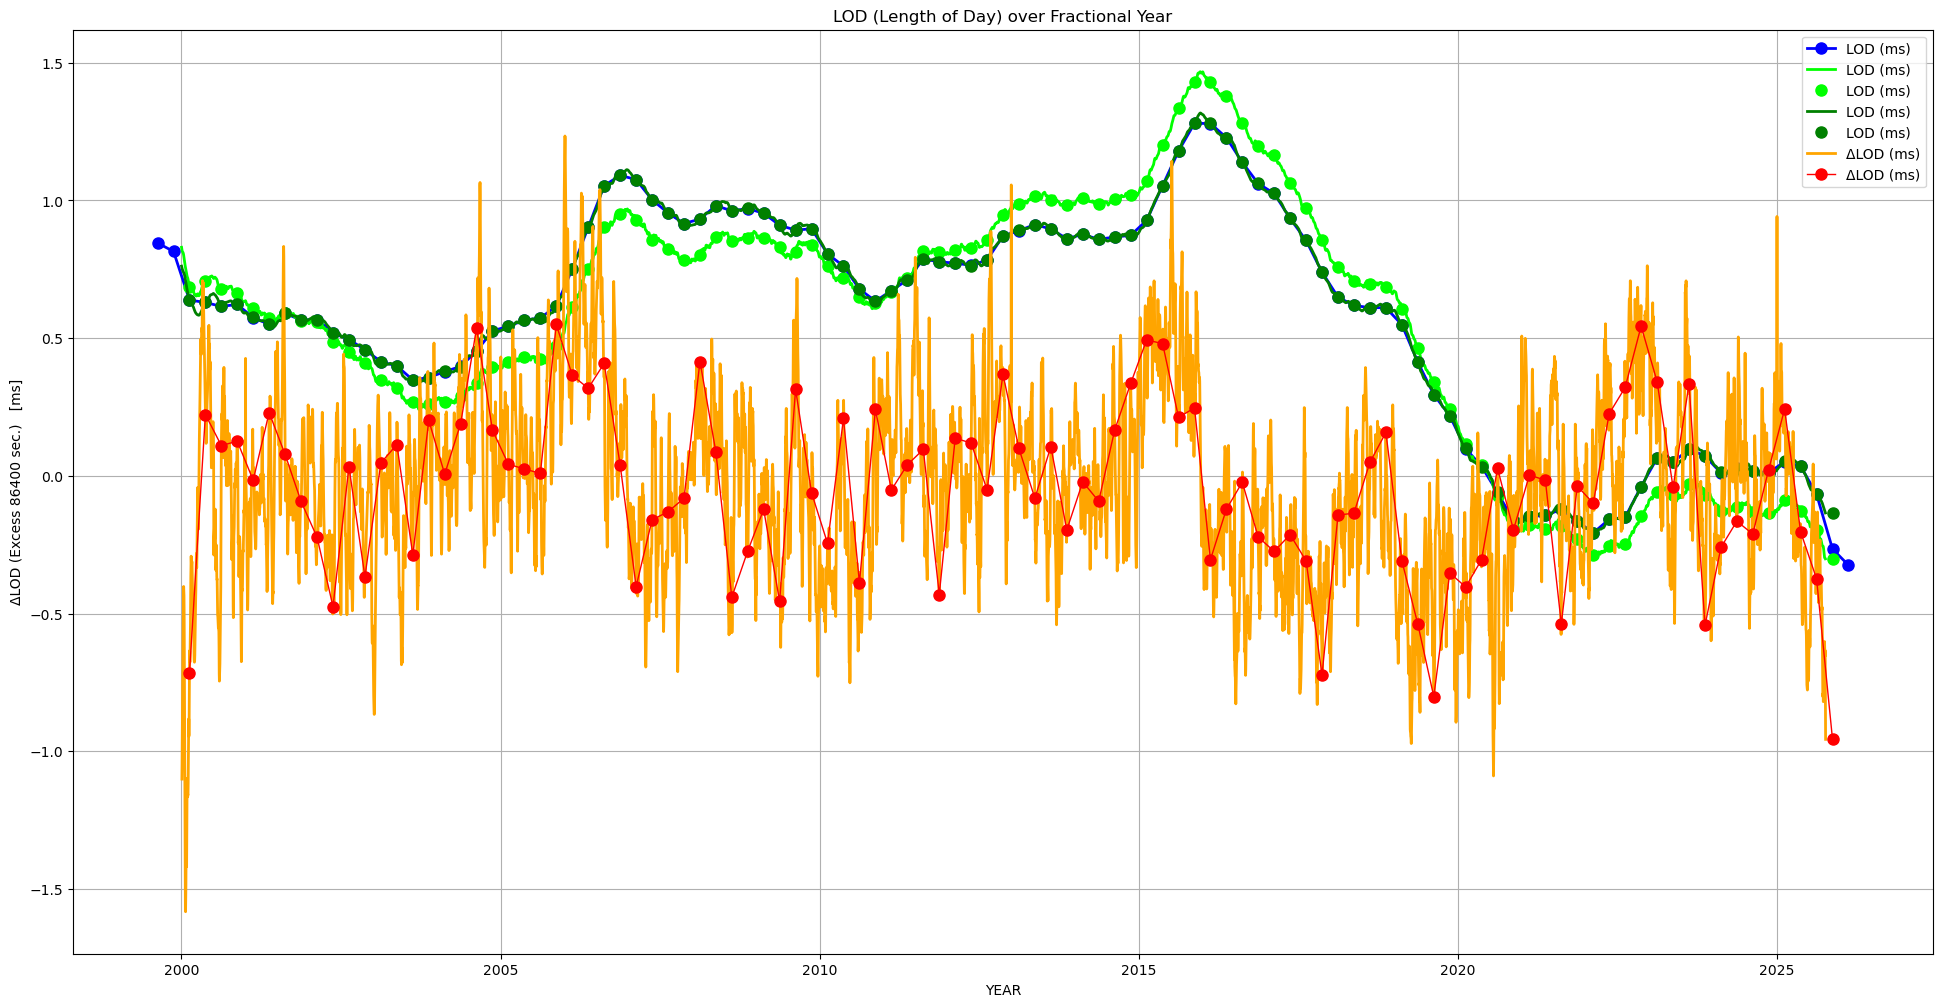

In [11]:
# プロット
plt.figure(figsize=(24, 12))
lod_rmT_qaverage['avg_lod'].plot(label='LOD (ms)', color='blue', linewidth=2, marker="o", markersize=8)

lod_raw_filtered['avg_lod'].plot(label='LOD (ms)', color='lime', linewidth=2)
lod_raw_fquarter['avg_lod'].plot(label='LOD (ms)', color='lime', linewidth=0, marker="o", markersize=8)
lod_rmT_filtered['avg_lod'].plot(label='LOD (ms)', color='green', linewidth=2)
lod_rmT_fquarter['avg_lod'].plot(label='LOD (ms)', color='green', linewidth=0, marker="o", markersize=8)

DlodDT_rmT_filtered['avg_lod'].plot(label='ΔLOD (ms)', color='orange', linewidth=2)
DlodDT_rmT_fquarter['avg_lod'].plot(label='ΔLOD (ms)', color='red', linewidth=1, marker="o", markersize=8)
plt.title('LOD (Length of Day) over Fractional Year')
plt.xlabel('YEAR')
plt.ylabel('ΔLOD (Excess 86400 sec.)   [ms]')
plt.grid(True)
plt.legend()
plt.show()

In [12]:
#save
save_df = lod_rmT_fquarter.iloc[23:]
display(save_df.head())

save_dir = "../data/processed"
save_df.to_csv(f"{save_dir}/lod.csv")



,avg_lod,std_lod
YEAR,,
2004.8739,0.527425,0.418462
2005.1237,0.544053,0.391140
2005.3739,0.565489,0.384749
2005.6241,0.572782,0.394213
2005.8742,0.616196,0.433872


In [13]:
#save
save_df = DlodDT_rmT_qaverage.iloc[23:]
display(save_df.head())

save_dir = "../data/processed"
save_df.to_csv(f"{save_dir}/DlodDT.csv")



,avg_lod,std_lod
YEAR,,
2005.1239,0.294026,2.215335
2005.3737,0.064935,2.292567
2005.6239,0.091088,2.195476
2005.8741,0.029172,2.203400
2006.1242,0.173657,2.344863


# Visualizations

In [14]:
%matplotlib inline
# print(plt.rcParams.keys())
plt.rcParams.update({
    'font.size'     : 16,
    'axes.grid'     : True,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
})

# font size
f_large  = 24
f_medium = 18
f_small  = 16
f_tiny   = 12

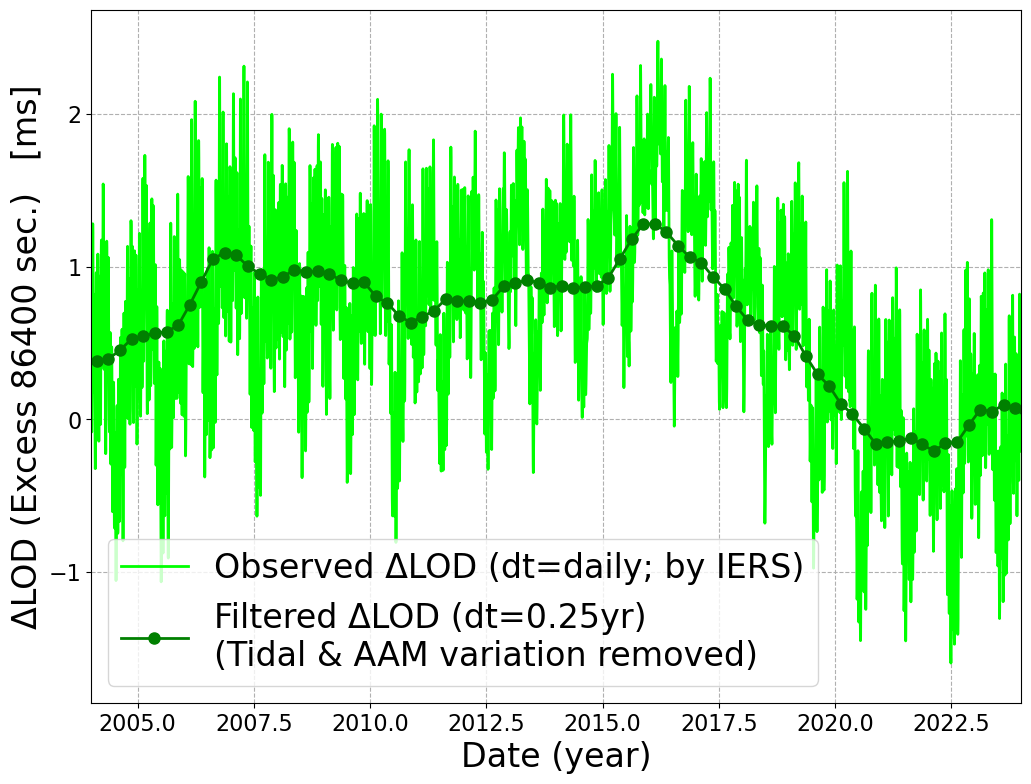

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

ax.plot(lod_raw_df['Fractional_Year'], lod_raw_df['lod'], 
        color='lime', linewidth=2.0, 
        label='Observed ΔLOD (dt=daily; by IERS)')

ax.plot(lod_rmT_fquarter.index.values, lod_rmT_fquarter['avg_lod'], 
        color='green', linewidth=2.0, marker="o", markersize=8,
        label='Filtered ΔLOD (dt=0.25yr) \n(Tidal & AAM variation removed)')

ax.set_xlim(2004, 2024)
ax.set_xlabel('Date (year)', fontsize=f_large)
ax.set_ylabel("ΔLOD (Excess 86400 sec.)   [ms]", fontsize=f_large)

ax.legend(loc='lower left', fontsize=f_large)
plt.show()

0.002737688371775942 9411
0.002737688371775942 9411
0.002737688371775942 9410


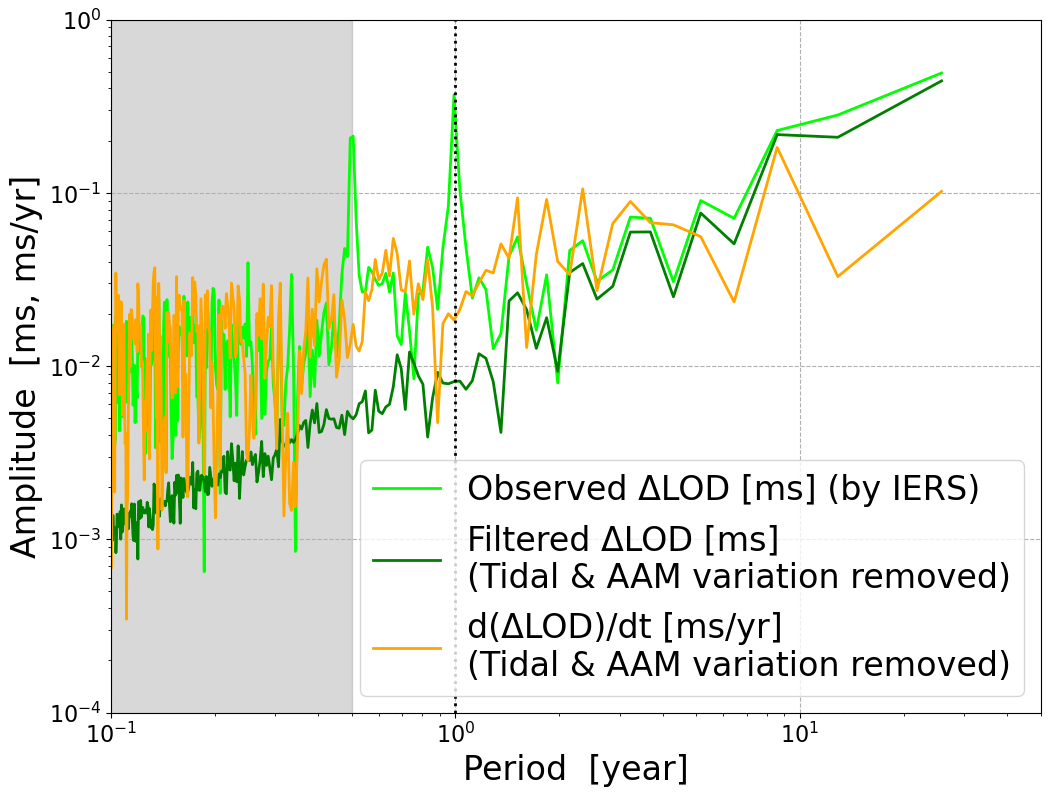

In [17]:
## FFT

N_raw = lod_raw_df['lod'].count()
print(daily, N_raw)
raw_fft = np.fft.fft(lod_raw_df['lod'])
raw_frq = np.fft.fftfreq(N_raw, d=daily)
raw_Amp = abs(raw_fft/(N_raw/2))

rmT_fft = np.fft.fft(lod_rmT_df['lod'])
rmT_frq = np.fft.fftfreq(N_raw, d=daily)
rmT_Amp = abs(rmT_fft/(N_raw/2))

# qyrly = 0.2502 # 0.25 yr
# N_flt = lod_rmT_qave['avg_lod'].count()
# print(qyrly, N_flt)
# flt_fft = np.fft.fft(lod_rmT_qave['avg_lod'])
# flt_frq = np.fft.fftfreq(N_flt, d=qyrly)
# flt_Amp = abs(flt_fft/(N_flt/2))
# failed: samplping rate was not enough for FFT

N_flt = lod_rmT_filtered['avg_lod'].count()
print(daily, N_flt)
flt_fft = np.fft.fft(lod_rmT_filtered['avg_lod'])
flt_frq = np.fft.fftfreq(N_flt, d=daily)
flt_Amp = abs(flt_fft/(N_flt/2))


N_ddt = DlodDT_rmT_filtered['avg_lod'].dropna().count()
print(daily, N_ddt)
ddt_fft = np.fft.fft(DlodDT_rmT_filtered['avg_lod'].dropna())
ddt_frq = np.fft.fftfreq(N_ddt, d=daily)
ddt_Amp = abs(ddt_fft/(N_ddt/2))

fig, ax = plt.subplots(1, 1, figsize=(12, 9))

ax.plot(1/raw_frq[1:int(N_raw/2)], raw_Amp[1:int(N_raw/2)], 
        color='lime', linewidth=2.0, 
        label="Observed ΔLOD [ms] (by IERS)") #A-f グラフのプロット

# ax.plot(1/rmT_frq[1:int(N_raw/2)], rmT_Amp[1:int(N_raw/2)], 
#         color='cyan', linewidth=2.0, 
#         label="Tidal-removed LOD (IERS)") #A-f グラフのプロット

ax.plot(1/flt_frq[1:int(N_flt/2)], flt_Amp[1:int(N_flt/2)], 
        color='green', linewidth=2.0, 
        label='Filtered ΔLOD [ms] \n(Tidal & AAM variation removed)') #A-f グラフのプロット

ax.plot(1/ddt_frq[1:int(N_ddt/2)], ddt_Amp[1:int(N_ddt/2)], 
        color='orange', linewidth=2.0, 
        label='d(ΔLOD)/dt [ms/yr] \n(Tidal & AAM variation removed)') #A-f グラフのプロット

ymin, ymax = 0.0001, 1
ax.set_ylim(ymin, ymax)
ax.set_xlim(0.1, 50)

ax.plot((1, 1), (ymin, ymax), color="black", linestyle="dotted")
ax.fill_betweenx(y=[0.00001, 1], x1=0.01, x2=0.5, color='gray', alpha=0.3) 
# Periods less than 2*dt = 0.5 yr will not be detected by RNN due to the Nyquist frequency

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("Period  [year]" , fontsize=f_large)
ax.set_ylabel("Amplitude  [ms, ms/yr]", fontsize=f_large)
ax.legend(loc='lower right', fontsize=f_large)
plt.show()